# Exploration notebook - Best Model Pipeline

## Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

## Datasources

Datasources for this notebooks are preprocessed dataframe (output from build_project.py)

transformers.py module contain full preprocessing pipeline.

Multiple preprocessing methodes was run :
- undersampling
- SMOTE
- no preprocess balancing (for baseine and class_weight define on model-fit level hypothesis)

### Import dataset from balancing script output

In [3]:
# load train datasets 
# - unbalanced datasets
base_path = '../datasets/compute'
transform_df_train_split = pd.read_csv(f"{base_path}/transform_df_train_split.csv")
transform_df_train_split_target = pd.read_csv(f"{base_path}/transform_df_train_split_target.csv")

# - undersampled datasets
undersample_df_train_split = pd.read_csv(f"{base_path}/undersample_df_train_split.csv")
undersample_df_train_split_target = pd.read_csv(f"{base_path}/undersample_df_train_split_target.csv")

# - oversample datasets
oversample_df_train_split = pd.read_csv(f"{base_path}/overersample_df_train_split.csv")  ## TODO : /!\ erreur nommenclature dans le nom du fichier a modifier...
oversample_df_train_split_target = pd.read_csv(f"{base_path}/oversample_df_train_split_target.csv")

In [4]:
# load eval datasets

transform_df_eval_split = pd.read_csv(f"{base_path}/transform_df_eval_split.csv")
transform_df_eval_split_target = pd.read_csv(f"{base_path}/transform_df_eval_split_target.csv")


### Check target balance for each split

Objectif : vérifier l'intégrité des datasets chargés pour l'études
- nombre de colones identiques d'un jeu de données a l'autre
- équilibre entre classes pour les jeux de données undersample et oversample
- déséquilibre entre classes pour les jeux de données 'transform_train' et eval
- conhérence des volumes de données pour chaque jeu de données

transform_df_train_split target balance: shape(246008, 127)


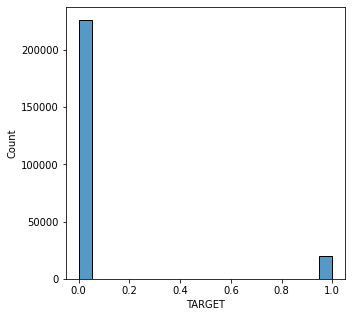

In [5]:
print(f"transform_df_train_split target balance: shape{transform_df_train_split.shape}")

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(data=transform_df_train_split_target, x="TARGET")
plt.show()

undersample_df_train_split target balance: shape(39720, 127)


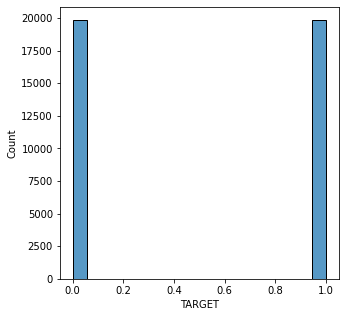

In [6]:
print(f"undersample_df_train_split target balance: shape{undersample_df_train_split.shape}")

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(data=undersample_df_train_split_target, x="TARGET")
plt.show()

oversample_df_train_split target balance: shape(452296, 127)


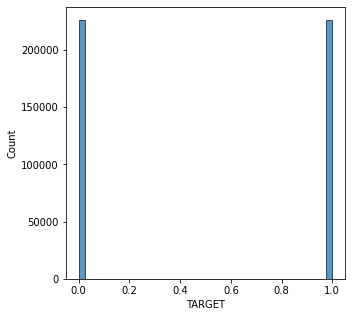

In [7]:
print(f"oversample_df_train_split target balance: shape{oversample_df_train_split.shape}")

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(data=oversample_df_train_split_target, x="TARGET")
plt.show()

transform_df_eval_split target balance: shape(61503, 127)


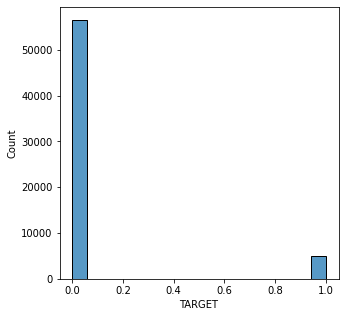

In [8]:
print(f"transform_df_eval_split target balance: shape{transform_df_eval_split.shape}")

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(data=transform_df_eval_split_target, x="TARGET")
plt.show()

## Best Balancing method ?

Objectif : identifier la méthode de balancing conférent les meilleurs résultats pour un modéle donnée
- modéle de référence == lgbm  (meilleur modéle a priori d'aprés la communauté kaggle pour ce jeu de donnée)
- Pas de GridSearchCV pour cette étape exploratoire -> configuration sur les params par default

In [9]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
      an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    print("Detail:")
    print(metrics.classification_report(y_true, y_pred))
    
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = metrics.confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    
    roc_auc = metrics.roc_auc_score(y_true, y_pred_proba)
    plt.subplot(222)
    fpr,tpr,_ = metrics.roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        #plt.subplot(212)
        xgb.plot_importance(model.named_steps['classifier'], max_num_features=20, height=0.2)
        plt.xticks(rotation=90)

    plt.show()

In [10]:
lgbm_params_base = params = {
    'objective':'binary',
    'n_jobs': 4
}



Processing unbalanced hypothesis ... 
(246008, 127)
(246008, 1)
n 0  226148
n 1 19860
fitting model...
evaluating model ...
   acc : 0.9192071931450498
   recall : 0.01591137965760322
   precision : 0.4876543209876543
   fbeta_1 : 0.03081724205188219
   fbeta_2 : 0.019728298871241636
   auc : 0.7600891086735165
Detail:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.49      0.02      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.70      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503



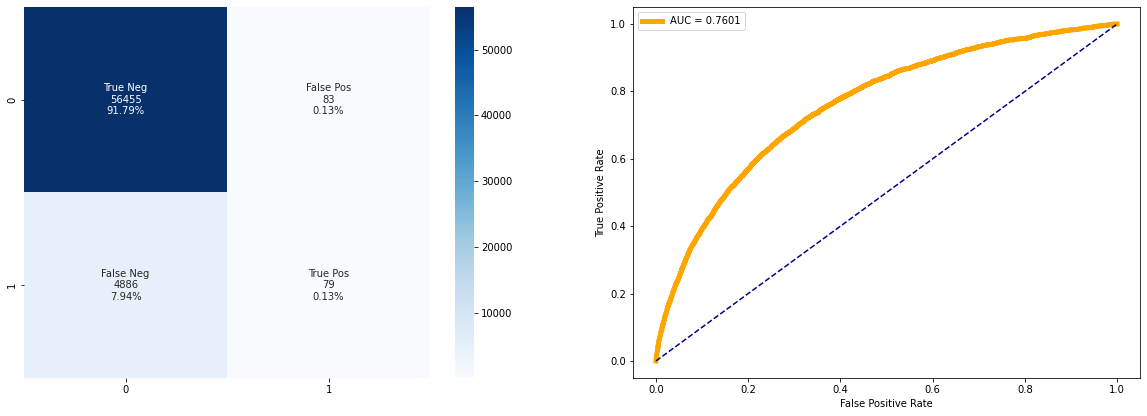


Processing class_weight hypothesis ... 
(246008, 127)
(246008, 1)
n 0  226148
n 1 19860
class_weight ratio : 11.38710976837865
fitting model...
evaluating model ...
   acc : 0.7079817244687251
   recall : 0.6815709969788519
   precision : 0.17122906441329758
   fbeta_1 : 0.27369783241669365
   fbeta_2 : 0.4270247078716906
   auc : 0.7619926987586564
Detail:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56538
           1       0.17      0.68      0.27      4965

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.77     61503



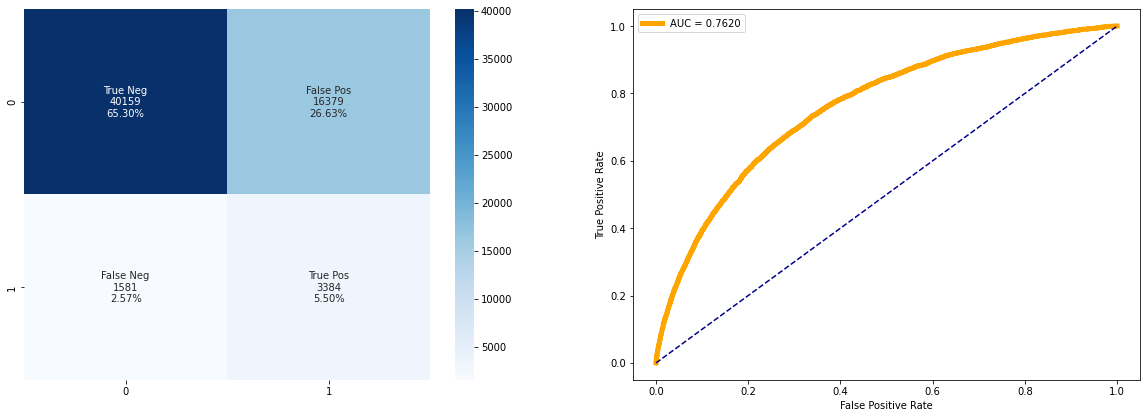


Processing undersampled hypothesis ... 
(39720, 127)
(39720, 1)
n 0  19860
n 1 19860
fitting model...
evaluating model ...
   acc : 0.692275173568769
   recall : 0.6860020140986909
   precision : 0.1639628363741395
   fbeta_1 : 0.2646670292952055
   fbeta_2 : 0.41911746609898354
   auc : 0.7555311603738462
Detail:
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56538
           1       0.16      0.69      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.69      0.76     61503



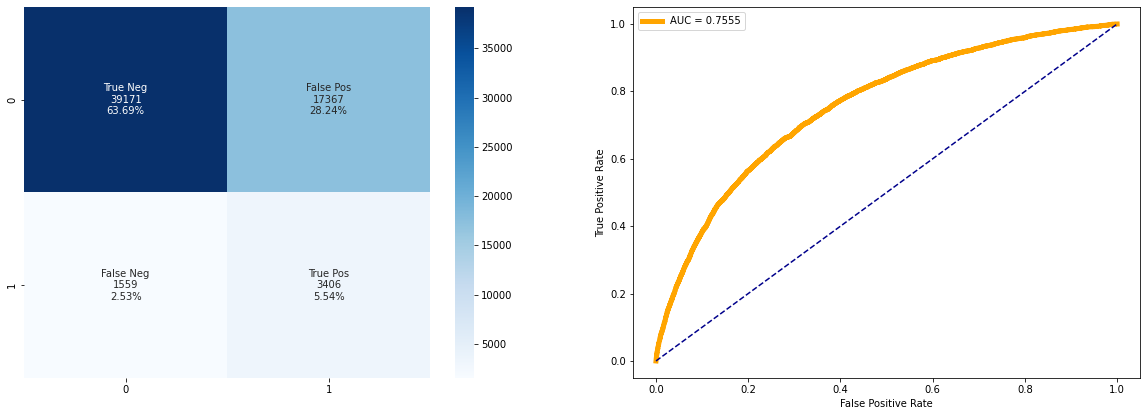


Processing oversapmled hypothesis ... 
(452296, 127)
(452296, 1)
n 0  226148
n 1 226148
fitting model...
evaluating model ...
   acc : 0.919386046209128
   recall : 0.014501510574018127
   precision : 0.5255474452554745
   fbeta_1 : 0.02822422579380635
   fbeta_2 : 0.01800270040506076
   auc : 0.7587889181609695
Detail:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.53      0.01      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.72      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503



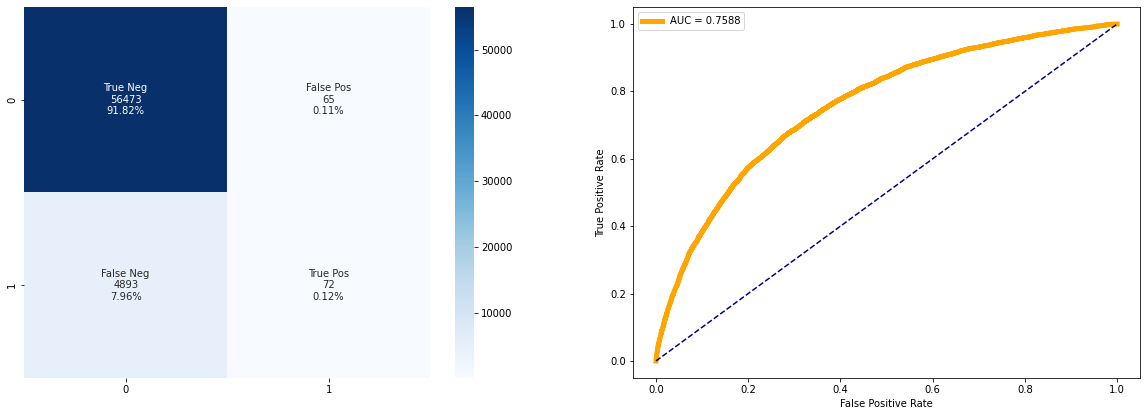

In [11]:
hypothesis_dfs = {
    'unbalanced' : (transform_df_train_split, transform_df_train_split_target),
    'class_weight': (transform_df_train_split, transform_df_train_split_target),
    'undersampled': (undersample_df_train_split, undersample_df_train_split_target),
    'oversapmled': (oversample_df_train_split, oversample_df_train_split_target)
    
}

hypothesis_scores = {}

for key, values in hypothesis_dfs.items():
    print(f"\nProcessing {key} hypothesis ... ")
    print(values[0].shape)
    print(values[1].shape)
    print("n 0 ", values[1].value_counts()[0])
    print("n 1" , values[1].value_counts()[1])
    
    if key != 'class_weight':
        classifier = lgb.LGBMClassifier(**lgbm_params_base)
    else:
        count_class_1 = values[1].value_counts()[0]
        count_class_2 = values[1].value_counts()[1]
        ratio = count_class_1 / count_class_2
        print(f"class_weight ratio : {ratio}")
        classifier = lgb.LGBMClassifier(class_weight={1:ratio, 0:1}, **lgbm_params_base)
        
    print("fitting model...")
    classifier.fit(values[0], values[1])
    
    print("evaluating model ...")
    predicted = classifier.predict(transform_df_eval_split)
    predicted_proba = classifier.predict_proba(transform_df_eval_split)
    
    score = classifier.score(transform_df_eval_split, transform_df_eval_split_target)
    recall = metrics.recall_score(transform_df_eval_split_target, predicted)
    precision = metrics.precision_score(transform_df_eval_split_target, predicted)
    fbeta_1 = metrics.fbeta_score(transform_df_eval_split_target, predicted, beta=1)
    fbeta_2 = metrics.fbeta_score(transform_df_eval_split_target, predicted, beta=2)
    roc_auc = metrics.roc_auc_score(transform_df_eval_split_target, predicted_proba[:,1])
    
    
    hypothesis_scores[key] = {
        'acc' : score,
        'recall' : recall,
        'precision' : precision,
        'fbeta_1' : fbeta_1,
        'fbeta_2' : fbeta_2,
        'auc' : roc_auc
    }
    for k, v in hypothesis_scores[key].items():
        print(f"   {k} : {v}")
    
    cf_matrix_roc_auc(classifier, transform_df_eval_split_target, predicted, predicted_proba[:,1], feature_importances=False)

In [12]:
hypothesis_scores_df = pd.DataFrame(hypothesis_scores).T
hypothesis_scores_df = hypothesis_scores_df.reset_index()

hypothesis_scores_df



,index,acc,recall,precision,fbeta_1,fbeta_2,auc
0,unbalanced,0.919207,0.015911,0.487654,0.030817,0.019728,0.760089
1,class_weight,0.707982,0.681571,0.171229,0.273698,0.427025,0.761993
2,undersampled,0.692275,0.686002,0.163963,0.264667,0.419117,0.755531
3,oversapmled,0.919386,0.014502,0.525547,0.028224,0.018003,0.758789


In [13]:
formated_h_scores = pd.melt(hypothesis_scores_df, id_vars=['index'], value_vars=['acc','fbeta_1','fbeta_2', 'auc'])
formated_h_scores.head(10)

,index,variable,value
0,unbalanced,acc,0.919207
1,class_weight,acc,0.707982
2,undersampled,acc,0.692275
3,oversapmled,acc,0.919386
4,unbalanced,fbeta_1,0.030817
5,class_weight,fbeta_1,0.273698
6,undersampled,fbeta_1,0.264667
7,oversapmled,fbeta_1,0.028224
8,unbalanced,fbeta_2,0.019728
9,class_weight,fbeta_2,0.427025


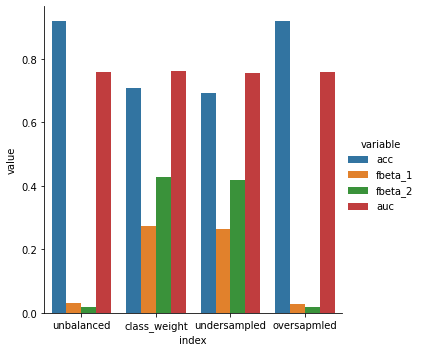

In [14]:
## plot bargraph for scores
ax = sns.factorplot(x='index', y='value', hue='variable', data=formated_h_scores, kind='bar')


## Scoring function

objectif : Définir une fonction score adapté a notre problématique pour l'entrainement des modèles

In [24]:
fbeta_scorer = metrics.make_scorer(metrics.fbeta_score, greater_is_better=True, beta=3)

## LGBM hyperparameters tunning 

Objectif : Identifier les hyperparamétres optimaux
- optmisation des paramétres par GridsearchCV
- optimisation du critéres identifié par la fonction score

In [25]:
params = {
            'max_depth': [1, 5],
            'n_estimators': [1000],
            'num_leaves': [10, 17, 24],
            'min_child_samples': [500],
            'min_child_weight': [1e-1, 1, 1e1, 1e2],
            'subsample': [0.8, 1],
            'colsample_bytree': [0.9],
            'reg_alpha': [2],
            'reg_lambda': [5]
        }

In [26]:
classifier = lgb.LGBMClassifier(random_state=314, **params)

In [27]:
grid = GridSearchCV(estimator=classifier,
                    param_grid=params,
                    cv=5,
                    n_jobs=4,
                    scoring=fbeta_scorer)

grid.fit(hypothesis_dfs['undersampled'][0], hypothesis_dfs['undersampled'][1])

GridSearchCV(cv=5,
             estimator=LGBMClassifier(colsample_bytree=[0.9], max_depth=[1, 5],
                                      min_child_samples=[500],
                                      min_child_weight=[0.1, 1, 10.0, 100.0],
                                      n_estimators=[1000],
                                      num_leaves=[10, 17, 24], random_state=314,
                                      reg_alpha=[2], reg_lambda=[5],
                                      subsample=[0.8, 1]),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.9], 'max_depth': [1, 5],
                         'min_child_samples': [500],
                         'min_child_weight': [0.1, 1, 10.0, 100.0],
                         'n_estimators': [1000], 'num_leaves': [10, 17, 24],
                         'reg_alpha': [2], 'reg_lambda': [5],
                         'subsample': [0.8, 1]},
             scoring=make_scorer(fbeta_score, beta=3))

In [28]:
lgbm = grid.best_estimator_


predicted = lgbm.predict(transform_df_eval_split)
predicted_proba = lgbm.predict_proba(transform_df_eval_split)

score = lgbm.score(transform_df_eval_split, transform_df_eval_split_target)
recall = metrics.recall_score(transform_df_eval_split_target, predicted)
precision = metrics.precision_score(transform_df_eval_split_target, predicted)
fbeta_1 = metrics.fbeta_score(transform_df_eval_split_target, predicted, beta=1)
fbeta_2 = metrics.fbeta_score(transform_df_eval_split_target, predicted, beta=2)
roc_auc = metrics.roc_auc_score(transform_df_eval_split_target, predicted_proba[:,1])
    
print(f"lgbm score : {score}")
print(f"lgbm recall {recall}")
print(f"lgbm precision {precision}")
print(f"lgbm fbeta_2 {fbeta_2}")
print(f"lgbm roc_auc {roc_auc}")

lgbm score : 0.6968765751264167
lgbm recall 0.6918429003021148
lgbm precision 0.1671695542145221
lgbm fbeta_2 0.42503959611958025
lgbm roc_auc 0.7581114460105025


In [29]:
grid.best_params_

{'colsample_bytree': 0.9,
 'max_depth': 5,
 'min_child_samples': 500,
 'min_child_weight': 0.1,
 'n_estimators': 1000,
 'num_leaves': 10,
 'reg_alpha': 2,
 'reg_lambda': 5,
 'subsample': 0.8}

Detail:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56538
           1       0.17      0.69      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503



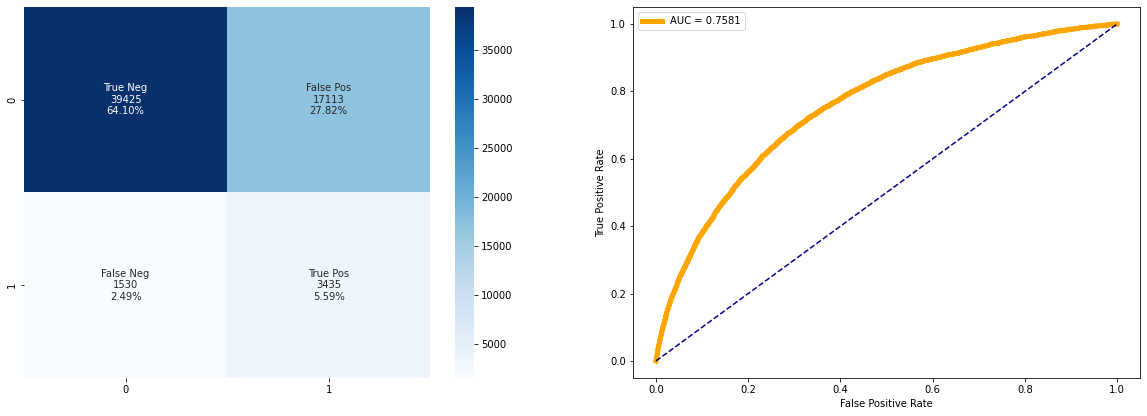

In [30]:
cf_matrix_roc_auc(lgbm, transform_df_eval_split_target, predicted, predicted_proba[:,1], feature_importances=False)

In [31]:
import shap

In [41]:
shap_values = shap.TreeExplainer(lgbm).shap_values(undersample_df_train_split)

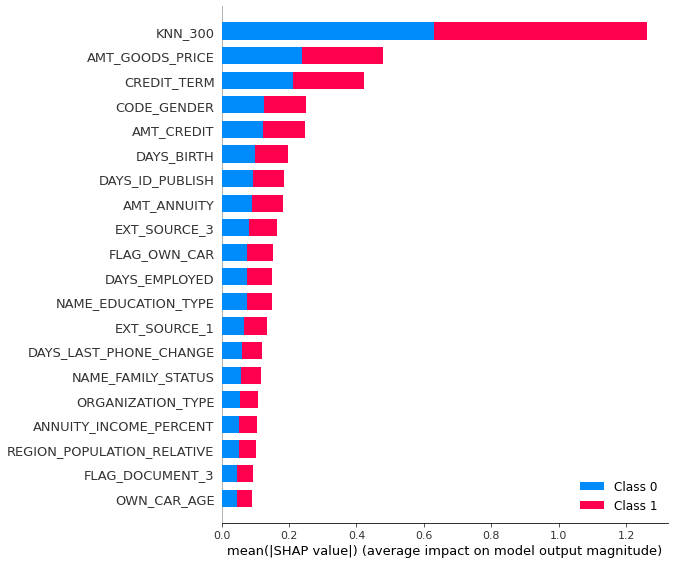

In [42]:
shap.summary_plot(shap_values, undersample_df_train_split)

In [44]:
shap.plots.waterfall(shap_values[0])

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'